# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.optimize import minimize


plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"

In [2]:
DATA_DIR = 'data'
SAVE_DIR = "plots"

# The Problems

Here are the problems:

Apply the logistic regression (linear classifier) algorithm discussed in the lab session to predict next-day rain based on the 10 years of daily weather observations from many locations within a country. The dataset contains many factors taken into consideration to specify whether it rained or not on that particular day. The training and testing dataset is provided in the files titled ‘weather_train.csv’ and ‘weather_test.csv’, respectively. Carry out the following tasks as assignment problems:

1. Inspect and plot some portion of the training data using pandas. Segregate the training and testing data into two separate variables consisting of ‘feature values’ and corresponding ‘predictions’ (the prediction column is titled ‘RainTomorrow’ in the dataset). To simplify the problem a bit, clean the whole data by carrying out the following sub-tasks:
    - Convert the predictions in the binary format by using ‘1’ for ‘YES’ and ‘0’ for ‘NO’.
    - Identify and drop the feature columns having datatype ‘object’.
    - Identify cells having ‘NaN’ or ‘NA’ values and replace them with mean values of their respective columns.
    - Normalize all the feature values by scaling them between 0 and 1. The values in feature matrix $X$ can be normalized as:
   $$
   X_{norm} = \frac{X - min(X)}{max(X) - min(X)}
   $$
Execute the above sub-tasks and display some portion of the data and its head after each data cleaning step.

2. Classify the cleaned dataset using binary classification algorithm discussed in the class and calculate the optimized weights and training set accuracy for the model (use Truncated Newton’s Method in SciPy for optimization).
3. Plot the cost history ($J$) vs. the number of iterations
4. Apply the trained model on the cleaned test dataset to predict the testing accuracy of the model.

## The Approach

We can formulate the problem of logistic regression as an optimization problem. For this, let's define some quantities.

Suppose the input data is $X \in \mathbb{R}^{m\times n}$ where $m$ is number of samples and $n$ number of fearures. The target variable $\mathbf{y}\in \mathbb{R}^m$ has just two possible values, say $0$ and $1$.

### Hypothesis Function

The hypothesis function for logistic regression is:
$$
h(\theta) = z(\mathbf{w}^TX)
$$
Here $\mathbf{w} \in \mathbb{R}^{n+1}$ is the weight including the bias term, that is $\mathbf{w} = [w_0, w_1, \cdots, w_n]$ and $z$ is a function, called the sigmoid function defined as:
$$
z = \frac{1}{1+e^{-x}}
$$

### Cost Function

The cost function which we will use for the logistic regression is
$$
  J(\hat{y}, \mathbf{y}) = \begin{cases}
    - \log(\hat{y}) & \text{if $\mathbf{y}=1$}\\
    - \log( 1 - \hat{y}) & \text{if $\mathbf{y}=0$}
  \end{cases}
$$

This can be rewritten as:
$$
J(\hat{y}, \mathbf{y}) = -\mathbf{y}\log(\hat{y}) - (1-\mathbf{y})\log( 1 - \hat{y})
$$

Note that $J$ is function of $\hat{y}$ which in turn is function of $\mathbf{w}$ and $X$, so, $J$ is function of $J(\mathbf{w}, X, \mathbf{y})$.

### Optimization Problem

Using these definitions, we can formulate the optimization problem as:
$$
\text{minimize}_{\mathbf{w}} \, J(\mathbf{w}, X, \mathbf{y})
$$

# Solving The Third Problem

## Problem 3.1

In [3]:
train = pd.read_csv(os.path.join(DATA_DIR, "weather_train.csv"))
test = pd.read_csv(os.path.join(DATA_DIR, "weather_test.csv"))
train.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
test.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,11-01-2014,PearceRAAF,19.0,44.5,0.0,NaN,13.1,E,54.0,E,...,27.0,10.0,1015.3,1009.7,NaN,NaN,31.2,42.9,No,No
1,12-01-2014,PearceRAAF,31.2,44.3,0.0,NaN,12.2,E,54.0,N,...,10.0,22.0,1007.7,1007.8,NaN,NaN,40.2,35.8,No,No
2,13-01-2014,PearceRAAF,19.3,30.3,0.0,NaN,9.4,WSW,46.0,SSW,...,63.0,43.0,1010.9,1009.5,7.0,2.0,23.2,27.6,No,No
3,14-01-2014,PearceRAAF,14.0,29.7,0.0,NaN,13.1,WSW,44.0,SSE,...,43.0,29.0,1012.2,1009.5,0.0,0.0,23.0,29.0,No,No
4,15-01-2014,PearceRAAF,12.7,27.9,0.0,NaN,12.4,W,50.0,NW,...,48.0,34.0,1008.4,1008.4,1.0,3.0,23.4,25.7,No,No


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52062 entries, 0 to 52061
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           52062 non-null  object 
 1   Location       52062 non-null  object 
 2   MinTemp        51538 non-null  float64
 3   MaxTemp        51672 non-null  float64
 4   Rainfall       50766 non-null  float64
 5   Evaporation    24047 non-null  float64
 6   Sunshine       18441 non-null  float64
 7   WindGustDir    46533 non-null  object 
 8   WindGustSpeed  46540 non-null  float64
 9   WindDir9am     46068 non-null  object 
 10  WindDir3pm     49611 non-null  object 
 11  WindSpeed9am   50930 non-null  float64
 12  WindSpeed3pm   50306 non-null  float64
 13  Humidity9am    51272 non-null  float64
 14  Humidity3pm    50667 non-null  float64
 15  Pressure9am    45067 non-null  float64
 16  Pressure3pm    45117 non-null  float64
 17  Cloud9am       29614 non-null  float64
 18  Cloud3

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29093 entries, 0 to 29092
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           29093 non-null  object 
 1   Location       29093 non-null  object 
 2   MinTemp        28922 non-null  float64
 3   MaxTemp        28954 non-null  float64
 4   Rainfall       28689 non-null  float64
 5   Evaporation    16976 non-null  float64
 6   Sunshine       16341 non-null  float64
 7   WindGustDir    28580 non-null  object 
 8   WindGustSpeed  28617 non-null  float64
 9   WindDir9am     27638 non-null  object 
 10  WindDir3pm     28783 non-null  object 
 11  WindSpeed9am   28938 non-null  float64
 12  WindSpeed3pm   28932 non-null  float64
 13  Humidity9am    28863 non-null  float64
 14  Humidity3pm    28110 non-null  float64
 15  Pressure9am    24890 non-null  float64
 16  Pressure3pm    24889 non-null  float64
 17  Cloud9am       17456 non-null  float64
 18  Cloud3

All the preprocessing steps which we are doing will also be done to the test dataset. This is why, we'll take both of the datasets together.

### (a)

We can easily convert this to 0 or 1 using `pandas` `apply` method.

In [7]:
train["RainTomorrow"] = train["RainTomorrow"].apply(lambda x: 0 if x=="No" else 1)
test["RainTomorrow"] = test["RainTomorrow"].apply(lambda x: 0 if x=="No" else 1)

In [8]:
train.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,0
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0


### (b)

In [9]:
object_cols_train = train.columns[train.dtypes == "object"]
object_cols_test = test.columns[test.dtypes == "object"]

object_cols_train, object_cols_test

(Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
        'RainToday'],
       dtype='object'),
 Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
        'RainToday'],
       dtype='object'))

These are the `object` columns. We'll drop them:

In [10]:
train.drop(object_cols_train, axis=1, inplace=True)
test.drop(object_cols_test, axis=1, inplace=True)

In [11]:
train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0


### (c)

Let's print some of the cells which are Null:

In [12]:
train[train.isna()]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These are all the cells with null values. We'll fill them by means.

In [13]:
cols = train.columns

for col in cols:
    train[col] = train[col].fillna(train[col].mean())
    test[col] = test[col].fillna(test[col].mean())

In [14]:
train.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainTomorrow     0
dtype: int64

In [15]:
test.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainTomorrow     0
dtype: int64

We see that there are no null values!

### (d)

Let's make sure that all the columns are numerical:

In [16]:
train.dtypes

MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustSpeed    float64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainTomorrow       int64
dtype: object

They are! Next, let's normalize the columns by:

$$
   X_{norm} = \frac{X - min(X)}{max(X) - min(X)}
$$

In [18]:
def scale_one(col, df):
    minimum = df[col].min()
    maximum = df[col].max()
    return (df[col]-minimum)/(maximum-minimum)

In [19]:
cols = train.columns

for col in cols:
   train[col] = scale_one(col, train)
   test[col] = scale_one(col, test)

In [20]:
for col in cols:
    print(col, "Max", max(train[col]), max(test[col]))
    print(col, "Min", min(train[col]), min(test[col]))

MinTemp Max 1.0 1.0
MinTemp Min 0.0 0.0
MaxTemp Max 1.0 1.0
MaxTemp Min 0.0 0.0
Rainfall Max 1.0 1.0
Rainfall Min 0.0 0.0
Evaporation Max 1.0 1.0
Evaporation Min 0.0 0.0
Sunshine Max 1.0 1.0
Sunshine Min 0.0 0.0
WindGustSpeed Max 1.0 1.0
WindGustSpeed Min 0.0 0.0
WindSpeed9am Max 1.0 1.0
WindSpeed9am Min 0.0 0.0
WindSpeed3pm Max 1.0 1.0
WindSpeed3pm Min 0.0 0.0
Humidity9am Max 1.0 1.0
Humidity9am Min 0.0 0.0
Humidity3pm Max 1.0 1.0
Humidity3pm Min 0.0 0.0
Pressure9am Max 1.0 1.0
Pressure9am Min 0.0 0.0
Pressure3pm Max 1.0 1.0
Pressure3pm Min 0.0 0.0
Cloud9am Max 1.0 1.0
Cloud9am Min 0.0 0.0
Cloud3pm Max 1.0 1.0
Cloud3pm Min 0.0 0.0
Temp9am Max 1.0 1.0
Temp9am Min 0.0 0.0
Temp3pm Max 1.0 1.0
Temp3pm Min 0.0 0.0
RainTomorrow Max 1.0 1.0
RainTomorrow Min 0.0 0.0


Now, all values are between 0 and 1.

In [21]:
train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,0.569921,0.454139,0.001617,0.038129,0.536788,0.289062,0.153846,0.289157,0.701031,0.212121,0.452579,0.477080,0.888889,0.560902,0.490196,0.439189,0.0
1,0.411609,0.503356,0.000000,0.038129,0.536788,0.289062,0.030769,0.265060,0.422680,0.242424,0.500832,0.488964,0.492462,0.560902,0.497549,0.495495,0.0
2,0.556728,0.516779,0.000000,0.038129,0.536788,0.304688,0.146154,0.313253,0.360825,0.292929,0.450915,0.504244,0.492462,0.250000,0.590686,0.470721,0.0
3,0.459103,0.568233,0.000000,0.038129,0.536788,0.132812,0.084615,0.108434,0.432990,0.151515,0.617304,0.573854,0.492462,0.560902,0.519608,0.545045,0.0
4,0.678100,0.664430,0.002695,0.038129,0.536788,0.265625,0.053846,0.240964,0.814433,0.323232,0.504160,0.458404,0.777778,1.000000,0.512255,0.617117,0.0


In [22]:
test.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
0,0.664835,0.954198,0.0,0.121439,0.922535,0.387097,0.412698,0.238095,0.262626,0.090909,0.567753,0.5216,0.472588,0.491987,0.788235,0.955882,0.0
1,1.000000,0.949109,0.0,0.121439,0.859155,0.387097,0.492063,0.476190,0.090909,0.212121,0.437393,0.4912,0.472588,0.491987,1.000000,0.781863,0.0
2,0.673077,0.592875,0.0,0.121439,0.661972,0.322581,0.349206,0.444444,0.626263,0.424242,0.492281,0.5184,0.875000,0.250000,0.600000,0.580882,0.0
3,0.527473,0.577608,0.0,0.121439,0.922535,0.306452,0.269841,0.476190,0.424242,0.282828,0.514580,0.5184,0.000000,0.000000,0.595294,0.615196,0.0
4,0.491758,0.531807,0.0,0.121439,0.873239,0.354839,0.174603,0.492063,0.474747,0.333333,0.449400,0.5008,0.125000,0.375000,0.604706,0.534314,0.0


## Problem 3.2

We have given the the formal definition of the optimization problem in the section 2.1. Here, we'll just optimize the cost function using `scipy.optimize.minimize` function.

### Defining Some Functions

First, let's define some functions

In [25]:
def sigmoid(x):
    """The sigmoid function"""
    return 1 / (1 + np.exp(-x))

def _get_loss(y_hat, y_true):
    """The loss function for logistic regression"""
    m = len(y_hat)
    return np.sum(-y_true * np.log(y_hat) - (1 - y_true) * (np.log(1 - y_hat))) / m

def _get_yhat(X, w):
    """To get the predicted values for a given weight vector w"""
    return sigmoid(np.dot(X, w.T))

def _get_weights(n):
        """Gets a random weight vector of size n"""
        w = np.random.random((n))
        return w

In [26]:
def loss(w, X, y_true):
    """
    The objective function. This is the function which will be used to optimize
    """
    y_hat = sigmoid(np.dot(X, w.T))
    m = len(y_hat)
    loss = np.sum(-y_true * np.log(y_hat) - (1 - y_true) * (np.log(1 - y_hat))) / m
    return loss

### Creating $X$ and $\mathbf{y}$

Here, we'll seperate $X$ and $\mathbf{y}$. Also, as our hypothesis function contains a bias term, we'll add a vector of $1$ to the $X$ so that $b$ is contained in $\mathbf{w}$.

In [27]:
X = train.drop("RainTomorrow", axis=1).values
y = train["RainTomorrow"]
ones = np.ones((X.shape[0], 1))
X = np.append(ones, X, axis=1)

test_X = test.drop("RainTomorrow", axis=1).values
test_y = test["RainTomorrow"]
ones = np.ones((test_X.shape[0], 1))
test_X = np.append(ones, test_X, axis=1)

We won't be creating a train-test split aswe already have a test set!

### Initializing $\mathbf{w}$

Next step is to initialize the weights. Instead of initializing them by zeros or ones, I'm doing a random initialization.

In [28]:
np.random.seed(42)
m, n = X.shape
init_weights = _get_weights(n)
init_weights

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451, 0.30424224])

### Optimization

Before optimization, we'll create a callback function which will be used for plotting purposes.

In [29]:
train_losses = []
test_losses = []
epoch = 1
def callback(w):
    global epoch
    print(f"On Iteration {epoch:3.0f}", end="\r")
    train_loss = loss(w, X, y)
    test_loss = loss(w, test_X, test_y)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    epoch+=1

The problem specifies that we need to use Truncated Newton's method. We'll use `scipy.optimize.minimize` function for this. We'll use `TNC` method for this.

In [30]:
train_losses = []
test_losses = []

optimizer = minimize(
    loss,
    init_weights,
    args=(X, y),
    method="TNC",
    options={"maxiter": 1000},
    callback=callback,
    tol=1e-8
)


In [31]:
w_final = optimizer["x"]
w_final

array([-5.57841148,  0.3942323 ,  1.43262747,  2.35296417, -0.07447357,
       -1.57413976,  5.29430146,  0.65212976, -1.73175333,  1.87786876,
        4.16884424,  0.41801538, -1.55171722,  0.11354733,  0.90514991,
        0.5589355 , -1.36817804])

So, these are the weights. Let's see the accuracy of the model on the train dataset to see whether the model is working or not.

In [32]:
def accuracy(y_true, y_pred):
    return np.mean(y_true==y_pred)

In [33]:
y_pred = _get_yhat(X, w_final)
y_pred = np.round(y_pred)

In [34]:
train_acc = accuracy(y, y_pred)
print(f"Training accuracy is: {train_acc*100:.2f}%")

Training accuracy is: 82.03%


## Problem 3.3

I've already used callback function to store the loss function at each iteration. Let's plot them!

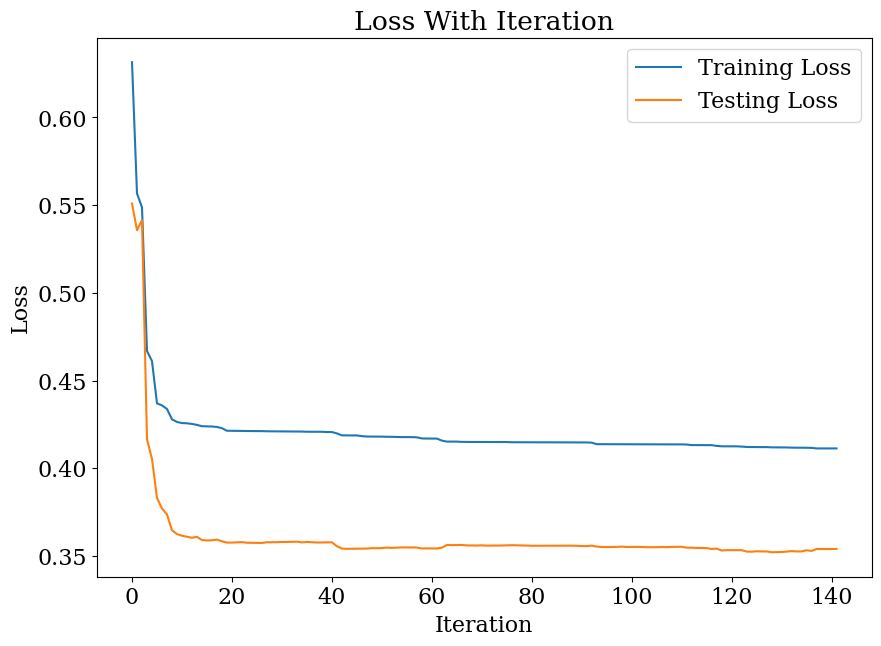

In [35]:
fig, ax = plt.subplots()
ax.plot(train_losses, label = "Training Loss")
ax.plot(test_losses, label = "Testing Loss")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("Loss With Iteration")
ax.legend()
fig.savefig(os.path.join(SAVE_DIR, "0301.png"))

Okay, we see that both the training and testing accuracy is descreasing with iteration. No significant change occurs after about 20 iterations.

## Problem 3.4

We have the model as `optimizer`. We also have the weights of the model which is all we need. Let's determine the testing accuracy.

In [36]:
y_pred = _get_yhat(test_X, w_final)
y_pred = np.round(y_pred)

test_acc = accuracy(test_y, y_pred)
print(f"Testing accuracy is: {test_acc*100:.2f}%")

Testing accuracy is: 84.78%


So, testing accuracy is greater than the train accuracy. Means model is not overfitting.

# Extra

I implemented logistic regression using gradient descent along with linear regression. The class `LogisticGradientDescent` is a subclass of `BatchGradientDescent`.
Let's see how this model performs.

In [46]:
from GD import LogisticGradientDescent

lgd = LogisticGradientDescent(fit_intercept=True, tol = 1e-6)

In [47]:
lgd.fit(X, y, epochs=10000, learning_rate=0.1, verbose=0)

In [49]:
train_acc = lgd.score(X, y)
test_acc = lgd.score(test_X, test_y)
print(f"Training accuracy is: {train_acc*100:.2f}%")
print(f"Testing accuracy is: {test_acc*100:.2f}%")

Training accuracy is: 81.88%
Testing accuracy is: 84.70%


The accuracy is almost same as that by optimizing. Let's plot the cost function.

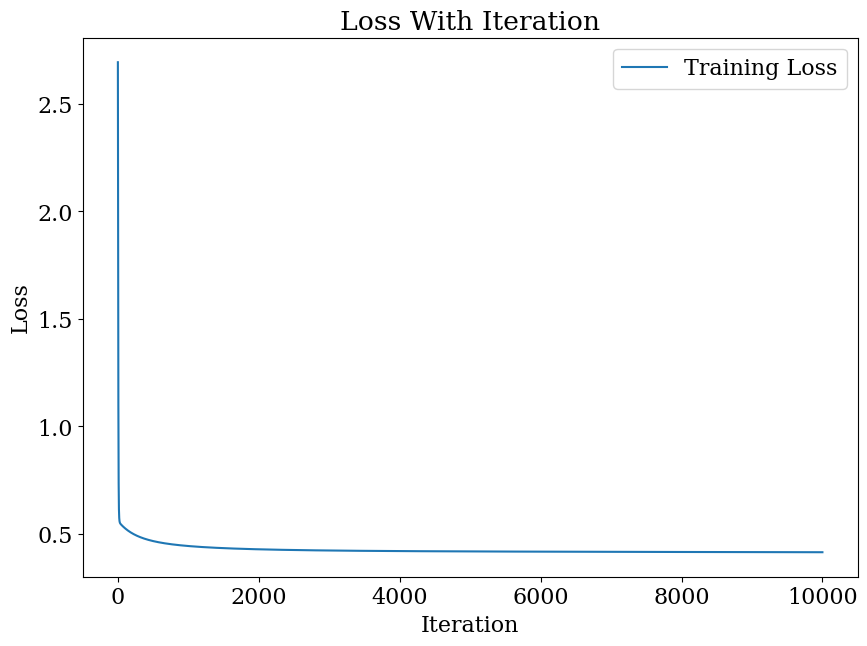

In [50]:
fig, ax = plt.subplots()
ax.plot(lgd._losses, label = "Training Loss")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("Loss With Iteration")
ax.legend()
fig.savefig(os.path.join(SAVE_DIR, "0302.png"))

The curve is much smoother.